In [45]:
%matplotlib inline
from __future__ import division
import numpy as np
np.random.seed(123456789)   # repeatable results
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import scipy.signal as sig
import scipy.constants as const
import corner
import emcee as mc
from matplotlib import style
style.use('dark_background')
plt.rc('lines',linewidth=2)


# Update the matplotlib configuration parameters:
plt.rcParams.update({'lines.linewidth': 2,
                     'font.size': 15,
                     'font.family': 'serif',
                     'figure.figsize': (15, 12),
                     'axes.grid': True,
                     'grid.color': '#555555'})


In [46]:
def complex_sine_gaussian(central_time, central_freq, amplitude, phase, decay, time):
    return amplitude * np.exp(- decay * np.square(time - central_time)) * np.exp(1j*(2*np.pi*central_freq*(time - central_time) + phase))

C:\Users\tvo88\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  # This is added back by InteractiveShellApp.init_path()


tc_true =  0.0
fc_true =  7.0
amp_true =  1.5
phs_true =  0.2
a_true =  10.939032383755034


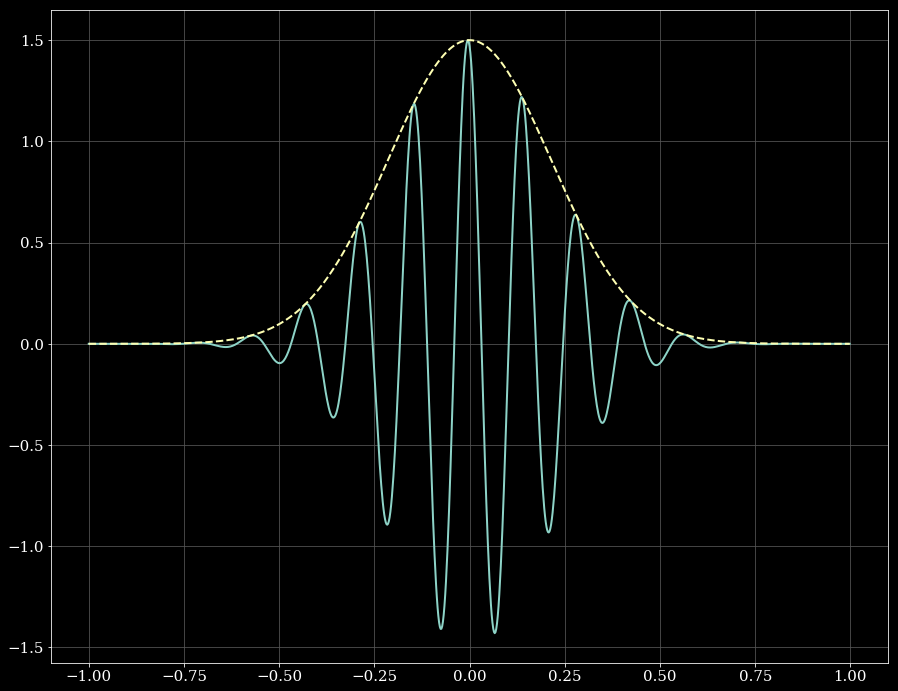

In [47]:
tc_true   =  0.0;     # 1 # seconds
fc_true   =  7.0;     # 2 # Hz
amp_true  =  1.5;     # 3 #
phs_true  =  0.2; # 4 # radians #

bw_true   =  0.25;    # Fractional = (Bandwidth/Central Frequency)
bwr_true  = -6.0;     # dB
duration  =  2.0;     # seconds
sample_f  =  500;     # Hz

t = np.linspace(-duration/2, duration/2, duration * sample_f, endpoint=False);

# sinegauss_r, sinegauss_i, e = sig.gausspulse(t, fc_true, bw_true, bwr_true, retquad=True, retenv=True);
# sinegauss = sinegauss_r * np.cos(phase) - sinegauss_i * np.sin(phase);

ref = pow(10.0, bwr_true/20.0);
a_true = -(np.pi * fc_true * bw_true)**2 / (4 * np.log(ref)) # 5 #
print( 'tc_true = ', tc_true)
print( 'fc_true = ', fc_true)
print( 'amp_true = ', amp_true)
print( 'phs_true = ', phs_true)
print( 'a_true = ', a_true)
sinegauss_c = complex_sine_gaussian(tc_true, fc_true, amp_true, phs_true, a_true, t);
envelope = amp_true * np.exp(- a_true * np.square(t-tc_true))
plt.plot(t, np.real(sinegauss_c), t, envelope, '--');
plt.show()

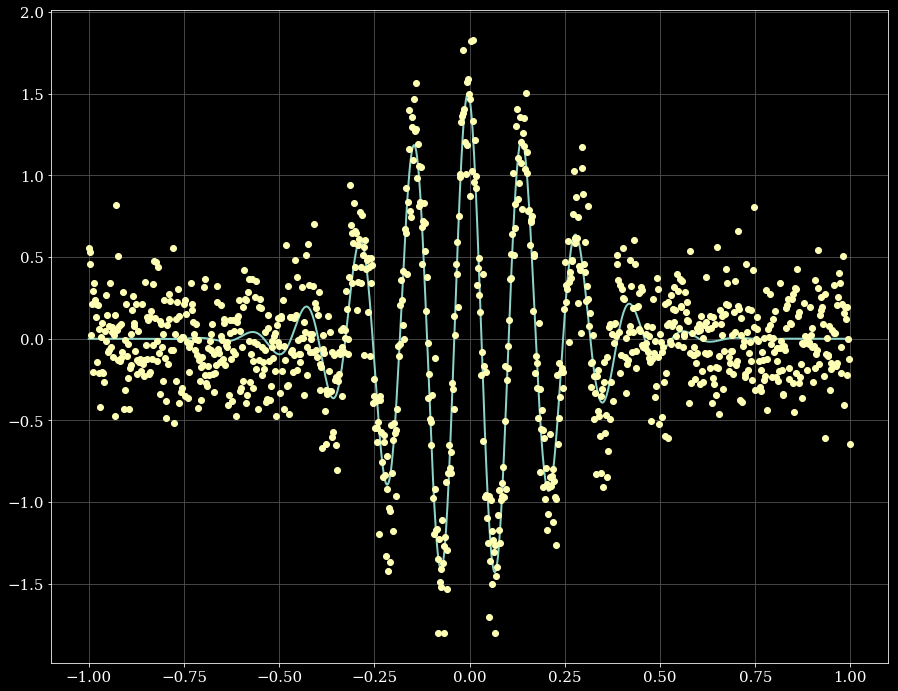

In [48]:
noise_mu = 0.0;
noise_std = 0.25;
noise = np.random.normal(noise_mu, noise_std, len(t));
# n, bins, patches = plt.hist(noise, 50, normed=1, facecolor='green')
# y = mlab.normpdf(bins, noise_mu, noise_std)
# plt.plot(bins, y, '--')
# plt.show()
signal = np.real(sinegauss_c) + noise;
plt.plot(t, np.real(sinegauss_c), t, signal, 'o');


In [49]:
Amp_signal = np.sqrt(np.mean(np.square(signal)));
Amp_noise  = np.sqrt(np.mean(np.square(noise)));
SNR = np.square(Amp_signal/Amp_noise)
print( 'RMS Amplitude of the signal = ', Amp_signal)
print( 'RMS Amplitude of the noise = ', Amp_noise)
print( 'SNR = ', SNR)

RMS Amplitude of the signal =  0.5292858634233512
RMS Amplitude of the noise =  0.24180215405913502
SNR =  4.791376059597924


In [50]:
# Define Log Likelihood
uncs = noise_std * np.ones(len(t))  # Uniform uncertainty in each point
def lnprob(theta, t, signal, uncs) :
    tc = theta[0]
    fc = theta[1]
    amplitude = theta[2]
    phase = theta[3]
    a = theta[4]
    
#     a = b * fc**2
    if tc < t[0] or t[-1] < tc or fc <= 0 or fc >= 0.5/(t[1]-t[0]) or amplitude <= 0 or amplitude > 5.0 or phase < -np.pi or phase >= np.pi or a <= 0 or a > 150.0 :
        return -np.inf
    else :
        new_signal = np.real(complex_sine_gaussian(tc, fc, amplitude, phase, a, t));
        return -np.sum(np.abs(signal - new_signal)**2/(2*np.square(uncs)))

In [51]:
ndim = 5
nwalkers = 100
rr = np.transpose(np.vstack([np.random.normal(0, 0.5, nwalkers), 
                             np.random.normal(0, 3.0, nwalkers),
                             np.random.normal(0, 1.0, nwalkers),
                             np.random.normal(0, 1.0, nwalkers),
                             np.random.normal(0, 5.0, nwalkers) ]))
p0 = np.tile(np.array([tc_true, fc_true, amp_true, phs_true, a_true]), (nwalkers,1)) + rr
rr[0]

array([ 0.21427576, -2.54804782, -0.83239283,  0.63902177, -9.00567585])

In [52]:
samp = mc.EnsembleSampler(nwalkers, ndim, lnprob, args=[t, signal, uncs])

In [53]:
pos, prob, state = samp.run_mcmc(p0, 1000)
samp.reset()

C:\Users\tvo88\Anaconda3\lib\site-packages\emcee\ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
C:\Users\tvo88\Anaconda3\lib\site-packages\emcee\ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


In [54]:
samp.run_mcmc(pos, 5000);

In [55]:
results = np.copy(samp.flatchain) 

Quantiles:
[(0.16, -0.0021646686096961935), (0.5, 0.005438628149993926), (0.84, 0.06735594463913802)]
Quantiles:
[(0.16, 6.981296463938522), (0.5, 7.000212379320829), (0.84, 7.022997561665154)]
Quantiles:
[(0.16, 1.4274696173068666), (0.5, 1.4948740213757978), (0.84, 1.5375112724839064)]
Quantiles:
[(0.16, -3.12215991037501), (0.5, 0.19825172638272212), (0.84, 0.5284573750655179)]
Quantiles:
[(0.16, 9.57472975459017), (0.5, 10.409968984063775), (0.84, 11.187696293727711)]


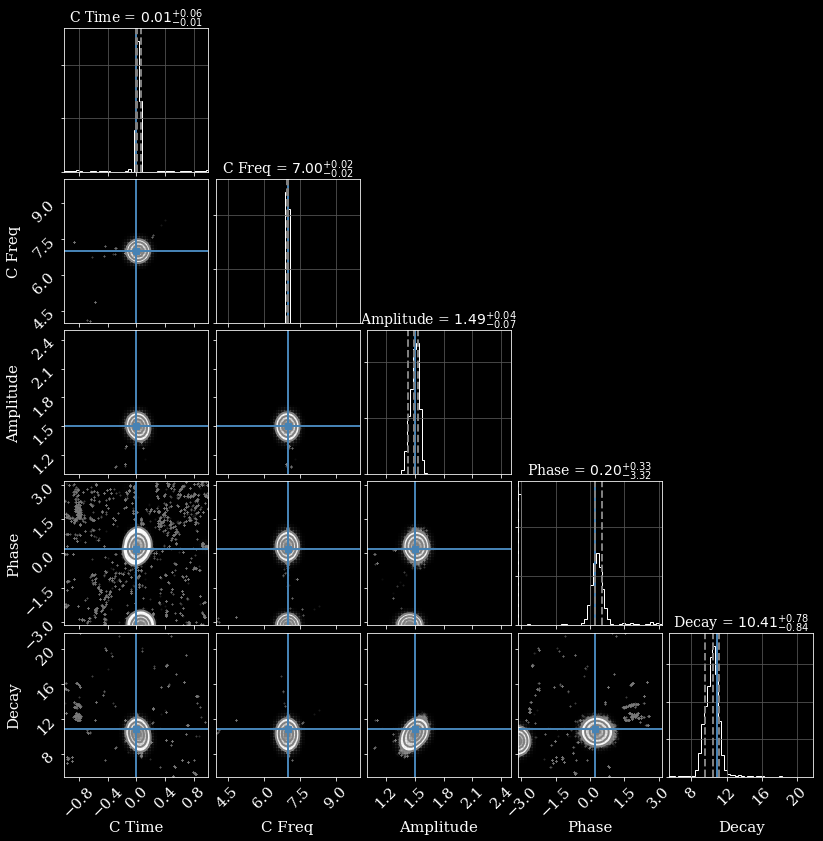

In [56]:
range_list = [[t[0], t[-1]], [fc_true-3, fc_true+3], [amp_true-0.5, amp_true+1.0], [-np.pi, np.pi], [a_true/2, a_true*2]]
h_c = corner.corner(results, 
                    color='0.5',
                    bins=50, 
                    labels=['C Time', 'C Freq', 'Amplitude', 'Phase', 'Decay'],
                    show_titles=True,
                    title_kwargs={'fontsize':14},
                    quantiles=[0.16, 0.5, 0.84],
                    truths=[tc_true, fc_true, amp_true, phs_true, a_true],
                    smooth=2,
                    range=range_list,
                    verbose=True,
                    hist_kwargs={'color':'w'})
h_c.savefig("SineGaussianTrianglePlots.pdf")

Means         =  0.02372139689364406 11.003648100334008 1.3665060717448596 -0.5529088791094757 15.640590355181118
Medians       =  0.005438628149993926 7.000212379320829 1.4948740213757978 0.19825172638272212 10.409968984063775
Uncertainties =  0.19735943454193264 16.179730389643773 0.4116221059461791 1.6525017515480118 21.99972064662609
Truths        =  0.0 7.0 1.5 0.2 10.939032383755034
[[ 3.89507464e-02  1.03771050e-01 -4.05853193e-03 -3.73274274e-02
  -4.33160873e-01]
 [ 1.03771050e-01  2.61783675e+02 -5.12981750e+00  6.89055451e+00
   3.14364332e+02]
 [-4.05853193e-03 -5.12981750e+00  1.69432758e-01 -1.37691602e-01
  -6.83680500e+00]
 [-3.73274274e-02  6.89055451e+00 -1.37691602e-01  2.73076204e+00
   9.45697096e+00]
 [-4.33160873e-01  3.14364332e+02 -6.83680500e+00  9.45697096e+00
   4.83987709e+02]]


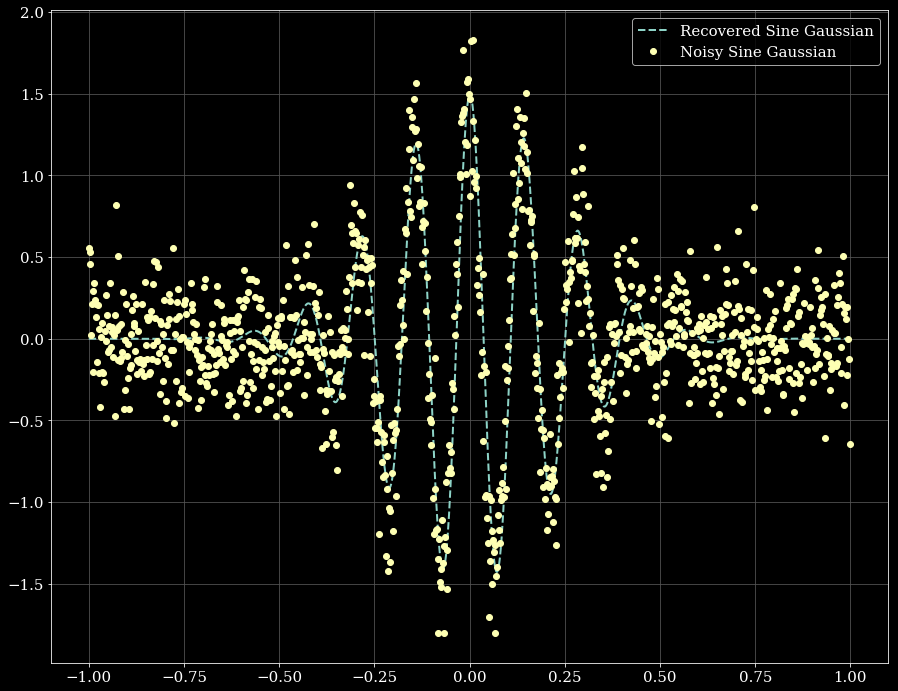

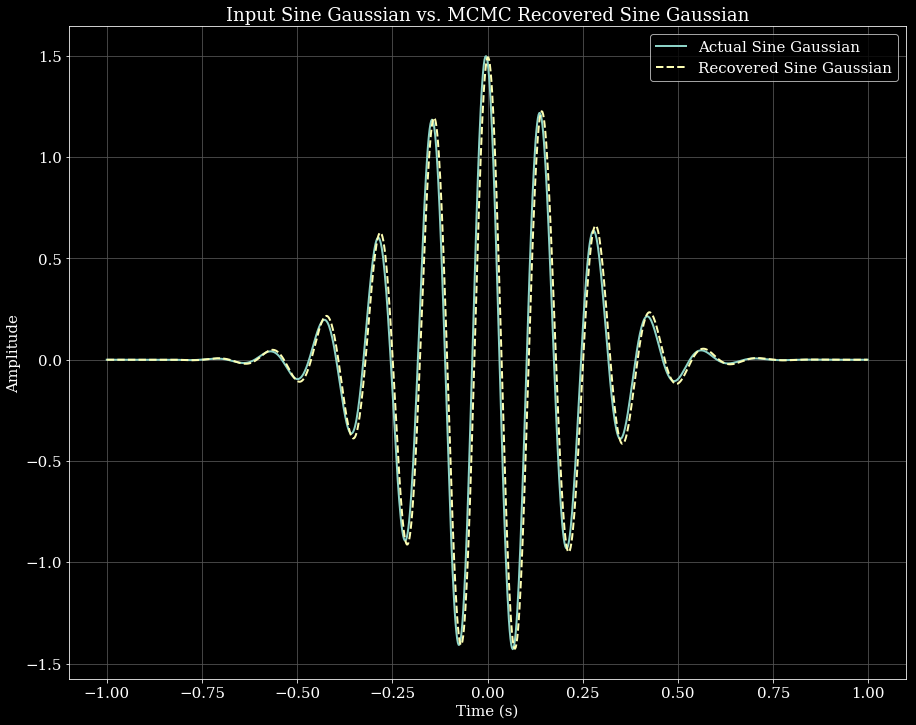

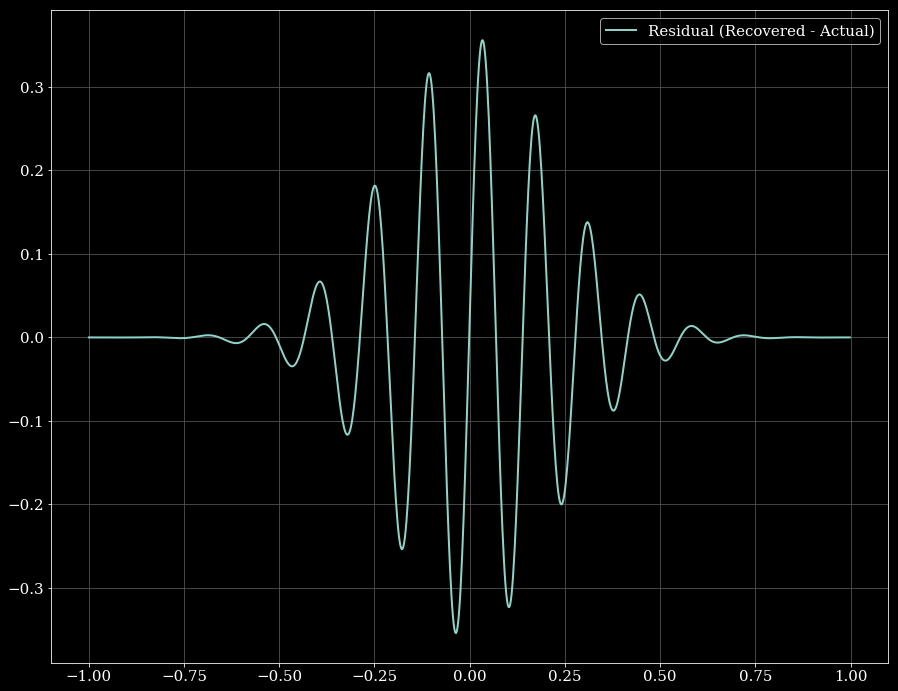

In [57]:
tc_mean, fc_mean, amp_mean, phs_mean, a_mean = np.mean(results,axis=0)
tc_median, fc_median, amp_median, phs_median, a_median = np.median(results,axis=0)
covmat = np.cov(results.T)
tc_unc, fc_unc, amp_unc, phs_unc, a_unc = np.sqrt(np.diag(covmat))
print( "Means         = ", tc_mean, fc_mean, amp_mean, phs_mean, a_mean)
print( "Medians       = ", tc_median, fc_median, amp_median, phs_median, a_median)
print( "Uncertainties = ", tc_unc, fc_unc, amp_unc, phs_unc, a_unc)
print( "Truths        = ", tc_true, fc_true, amp_true, phs_true, a_true)
print( covmat)

recovered_sinegauss = complex_sine_gaussian(tc_median, fc_median, amp_median, phs_median, a_median, t);
plt.plot(t, np.real(recovered_sinegauss), '--',label='Recovered Sine Gaussian')
plt.plot(t, signal, 'o', label='Noisy Sine Gaussian')
plt.legend(loc='best');
plt.show();
plt.plot(t, np.real(sinegauss_c), label='Actual Sine Gaussian')
plt.plot(t, np.real(recovered_sinegauss), '--', label='Recovered Sine Gaussian')
plt.legend(loc='best');
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Input Sine Gaussian vs. MCMC Recovered Sine Gaussian')
plt.savefig('ActualvsRecoveredSineGaussian.pdf')
plt.show();
plt.plot(t, np.real(recovered_sinegauss) - np.real(sinegauss_c), label='Residual (Recovered - Actual)')
plt.legend(loc='best');